In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multivariate GRU

**Changes**:

* More layers
* More units
* More features

In [17]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

## Load Dataset

In [32]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

from config import processed_data_dir

dataset_version = 'v4'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)
class_weight = 1-train_features_df.y.value_counts(normalize=True)

### Imput missing values

In [33]:
def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], np.nan)

    # replace all nans with the median value of all farms on that timestamp
    for ts, ts_df in df.groupby('time'):
        df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df
        
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)

train_features_df.head()

,farm_id,time,ndvi_mean,ndvi_median,cvi_mean,cvi_median,evi_mean,evi_median,arvi2_mean,arvi2_median,...,band_7_median,band_8_mean,band_8_median,band_8a_mean,band_8a_median,band_11_mean,band_11_median,band_12_mean,band_12_median,y
0,1,2017-01-01,0.671766,0.692653,3.001651,0.947159,2.474928,0.0,0.605966,0.630404,...,0.0,1774.600000,0.0,1945.271429,0.0,986.121429,0.0,496.128571,0.0,Vineyard
1,1,2017-01-31,0.718396,0.729027,2.744553,1.052384,2.208423,0.0,0.660523,0.672961,...,0.0,1878.164286,0.0,1941.592857,0.0,992.671429,0.0,521.650000,0.0,Vineyard
2,1,2017-02-10,0.746055,0.755768,1.977070,1.065654,2.510243,0.0,0.692884,0.704249,...,0.0,2199.185714,0.0,2474.121429,0.0,1106.557143,0.0,508.700000,0.0,Vineyard
3,1,2017-03-12,0.668629,0.684211,2.180335,0.865489,3.435664,0.0,0.602296,0.620526,...,0.0,1573.342857,0.0,1719.757143,0.0,898.800000,0.0,466.950000,0.0,Vineyard
4,1,2017-03-22,0.659258,0.673052,2.783775,1.226074,4.197762,0.0,0.591332,0.607470,...,0.0,1549.492857,0.0,1729.335714,0.0,871.714286,0.0,433.728571,0.0,Vineyard


## Normalize Features Dataset

Neural Nets are sensitive to scale, but we want to keep the variance in the features. So we will MinMax scale each feature on a specific time step over all farms. 

I.e - the network will see any number of variables at a time, but all of them will be on the same scale (0 - 1) and the variance between farms will be kept the same. 

In [34]:
# Make copies to compare before / after normalization
train_copy = train_features_df.copy()
test_copy = test_features_df.copy()

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

times = train_features_df['time'].unique()
feature_cols = [col for col in test_features_df.columns if col not in ['farm_id','time']]

for ts in times:
    scaler = StandardScaler()
    
    train_ts_df = train_copy[train_copy.time == ts]
    test_ts_df = test_copy[test_copy.time == ts]
    
    train_features_df.loc[train_ts_df.index, feature_cols] = scaler.fit_transform(train_ts_df[feature_cols])
    test_features_df.loc[test_ts_df.index, feature_cols] = scaler.transform(test_ts_df[feature_cols])

## Transform Dataset for MVTS Classification

In [36]:
def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, 11, n_features))
    
    classes = {}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes
    

In [37]:
train_data, train_labels_dict = transform_dataset(train_features_df)
test_data, _ = transform_dataset(test_features_df)

print('Train data:\t\t',train_data.shape)
print('Test data:\t\t',test_data.shape)

Train data:		 (2494, 11, 34)
Test data:		 (1074, 11, 34)


## Start Modelling Process

### Create validation set

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

seed = 420

# Copy for later
data = train_data.copy()

train_labels = list(train_labels_dict.values())
train_indexes = list(train_labels_dict.keys())
train_idx, val_idx, train_labels, val_labels = train_test_split(train_indexes, train_labels, stratify=train_labels, test_size=0.2, random_state=seed)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

print('train data : ',train_data.shape)
print('val data : ',val_data.shape)

train data :  (1995, 11, 34)
val data :  (499, 11, 34)


### Create model

In [39]:
import tensorflow as tf
import keras
from keras import models, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras import models, layers
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import ReduceLROnPlateau

from src.visualization.tf_viz import PlotLosses
from src.models.clr_callback import CyclicLR
# from src.models.sgdr import SGDRScheduler

## Set trainig params
epoch_size=1000
batch_size=512

# def get_model(n_features):

#     model = models.Sequential()
#     model.add(layers.Dense(8, activation='relu', input_shape=(11, n_features)))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.1))
#     model.add(layers.Dense(16, activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.2))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.2))
#     model.add(layers.GRU(8, input_shape=(11, n_features), kernel_regularizer=keras.regularizers.l2(0.02), return_sequences=True))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(16, activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.1))
#     model.add(layers.Dense(9, activation='softmax'))
#     return model


def get_model(n_features):
    
    GRU_cells = 16
    batch_size = 128
    recurrent_activation = 'hard_sigmoid'
    recurrent_dropout = 0.6093571771811351

    model = models.Sequential()
    model.add(layers.GRU(GRU_cells,input_shape=(11, n_features), return_sequences=True,recurrent_activation=recurrent_activation, recurrent_dropout=recurrent_dropout))
    model.add(layers.GRU(GRU_cells,input_shape=(11, n_features), return_sequences=True,recurrent_activation=recurrent_activation, recurrent_dropout=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(9))
    model.add(layers.Activation('softmax'))
    
    return model


In [40]:
# Get the model
model = get_model(train_data.shape[-1])
model.summary()

W0725 21:20:23.890881 4568008128 nn_ops.py:4224] Large dropout rate: 0.609357 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0725 21:20:23.903383 4568008128 nn_ops.py:4224] Large dropout rate: 0.609357 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 11, 16)            2448      
_________________________________________________________________
gru_5 (GRU)                  (None, 11, 16)            1584      
_________________________________________________________________
flatten_3 (Flatten)          (None, 176)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 1593      
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 5,625
Trainable params: 5,625
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Choose optimizer
# optimizer = keras.optimizers.Adam(3e-4)
optimizer = keras.optimizers.RMSprop(lr=0.0005,
    rho=0.9,
    epsilon=1e-07)


# optimizer = keras.optimizers.SGD()

# Choose callbacks
callbacks = [
    PlotLosses(),
    EarlyStopping(monitor='val_loss', verbose=1, patience=100),
    ReduceLROnPlateau(monitor='val_loss', patience=50),
#     CyclicLR(base_lr=0.0003, max_lr=0.005, step_size=train_data.shape[0]*4)
]

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy'
)

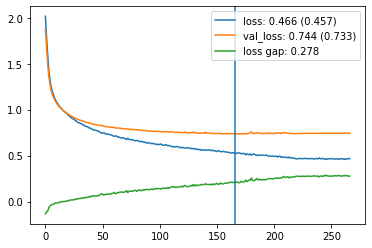

Epoch 00267: early stopping


In [42]:
model.fit(train_data, 
          train_labels_enc,
          batch_size=128,
          validation_data=(val_data, val_labels_enc), 
          class_weight=class_weight,
          verbose=0,
          epochs=epoch_size, 
          callbacks=callbacks)

In [ ]:
from sklearn.metrics import log_loss

val_preds = model.predict(val_data)
train_preds = model.predict(train_data)
print('val loss: ',log_loss(val_labels_enc, val_preds))
print('train loss: ',log_loss(train_labels_enc, train_preds))

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_preds = model.predict_classes(val_data)

cm = confusion_matrix(val_labels_enc, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

## Make Submission

### First retrain on all data


In [ ]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()

In [ ]:
model = get_model(all_data.shape[-1])
optimizer = keras.optimizers.RMSprop()
model.compile(optimizer=optimizer,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.fit(all_data, 
          all_labels,
          batch_size=64, 
          class_weight=class_weight,
          verbose=2,
          epochs=350, 
          workers=4, 
          use_multiprocessing=True,
          callbacks=[plot_losses, es, reduce_lr])

In [ ]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict(test_data)
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

### Save submission file

In [ ]:
from config import subs_dir

sub_df.to_csv(subs_dir / 'gru_vi_data_v4.1.csv')

### Save model architecture

In [ ]:
with open(subs_dir / 'architectures')